In [134]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import warnings

(data code)
```python
import os
results = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
#         print(os.path.join(dirname, filename))
        if image_path.endswith('.jpg') or image_path.endswith(".png"):
            results.append(image_path)

SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader


np.random.seed(123)
all_images = results
train_range = int(0.8 * len(all_images))
rand_idxs = np.random.permutation(len(all_images))
train_idxs = rand_idxs[:train_range] 
val_idxs = rand_idxs[train_range:] 
train_paths = [all_images[x] for x in train_idxs]
val_paths = [all_images[x] for x in val_idxs]
print(len(train_paths), len(val_paths))

```

In [5]:
images_paths = list()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        if image_path.endswith('.jpg') or image_path.endswith(".png"):
            images_paths.append(image_path)
images_paths[:5]

['/kaggle/input/ukrainewar2022part0/img_2022/SEP27 Kharkiv Infrastructural facilities damaged by rocket attacks 2.jpg',
 '/kaggle/input/ukrainewar2022part0/img_2022/MAR21 Kyiv Podil district night bombing of Retroville Mall and residential area 5 (Highlights).jpg',
 '/kaggle/input/ukrainewar2022part0/img_2022/AUG27 BS Bakhmut Donetsk region As result of shelling, premises of shop were on fire 2.jpg',
 '/kaggle/input/ukrainewar2022part0/img_2022/OCT23 Mykolaiv Result rocket attack houses, cars, thermal road and childrens playground were destroyed 5.jpg',
 '/kaggle/input/ukrainewar2022part0/img_2022/NOV17 Donetsk region Windows, doors in multi-apartment buildings broken, private houses and garages destroyed by shelling 8.jpg']

In [23]:
class ColorizationDataset(Dataset):
    # def __init__(self, paths, split='train'):
    def __init__(self, paths):
        """
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        """
        
        # self.split = split
        # self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        """
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}
        """
        return self.paths[idx]

    def __len__(self):
        return len(self.paths)
    
    
def make_dataloader(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [24]:
np.random.seed(123)
all_images = images_paths
train_range = int(0.8 * len(all_images))
rand_idxs = np.random.permutation(len(all_images))
train_idxs = rand_idxs[:train_range] 
val_idxs = rand_idxs[train_range:] 
train_paths = [all_images[x] for x in train_idxs]
val_paths = [all_images[x] for x in val_idxs]
print(len(train_paths), len(val_paths))

11019 2755


In [36]:
_dataloader = make_dataloader(paths=train_paths[:16*5])
for _batch in _dataloader:
    print(len(_batch), '\t', _batch[0])

16 	 /kaggle/input/ukraine-images-2023/img_2023/JAN29 Kherson Apartment buildings, private houses, clinic damaged by shelling 3.jpg
16 	 /kaggle/input/ukrainewar2022part0/img_2022/JUL03 Yurkivka Zaporizhzhia region As result of shelling, private house, car were damaged 3.jpg
16 	 /kaggle/input/ukraine-images-2023/img_2023/FEB16 Pavlohrad Dnipropetrovsk region Shelling destroyed private houses, outbuildings 15.jpg
16 	 /kaggle/input/ukrainewar2022part0/img_2022/JUL04 Donetsk region Occupiers shelled 13 settlements during day, residential buildings were damaged 1.jpg
16 	 /kaggle/input/ukraine-images-2023/img_2023/MAR04 Zaporizhzhia Elimination of consequences of rocket attack on residential building continues 10.jpg


In [38]:
train_loader = make_dataloader(paths=train_paths)
val_loader = make_dataloader(paths=val_paths)
len(train_loader), len(val_loader)

(689, 173)

In [43]:
def get_name_from_path(path):
    return path.split('/')[-1]

get_name_from_path(_batch[0])

'MAR04 Zaporizhzhia Elimination of consequences of rocket attack on residential building continues 10.jpg'

In [58]:
def save_grayscale_batch(batch):
    for img_path in batch:
        img_rgb = Image.open(img_path)
        img_gray = img_rgb.convert('L')
        img_gray.save(f'GRAYSCALE {get_name_from_path(img_path)}')
        
save_grayscale_batch(_batch)

In [103]:
def load_grayscale_batch(batch):
    return [f'GRAYSCALE {get_name_from_path(img_path)}' for img_path in batch]

load_grayscale_batch(_batch)

['GRAYSCALE MAR04 Zaporizhzhia Elimination of consequences of rocket attack on residential building continues 10.jpg',
 'GRAYSCALE MAY30 Kharkiv region More than 1500 people evacuated from temporarily occupied territories 8.jpg',
 'GRAYSCALE MAR14 Kherson Shopping center, heating line, administrative building, minibus, private house damaged by shelling 4 BS.jpg',
 'GRAYSCALE MAY23 Sumy region Private households damaged by shelling 1.jpg',
 'GRAYSCALE MAY08 Odesa region Food factory catches fire after missile strike 17 BS.jpg',
 'GRAYSCALE FEB02 Kramatorsk Donetsk region Search operations ongoing at site of missile strike, deceased 7.jpg',
 'GRAYSCALE MAR03 Donetsk region Private houses, outbuildings shelled 12.jpg',
 'GRAYSCALE FEB16 Kherson Heating networks, boiler house in city center damaged due to night shelling 3.jpg',
 'GRAYSCALE MAY27 Luhansk region Instead of the last bell, enemy guns sounded today 4.jpg',
 'GRAYSCALE MAY09 Zaporizhzhia region Private households damaged by shel

In [104]:
def del_grayscale_batch(batch):
    for img_path in batch:
        os.remove(f'GRAYSCALE {get_name_from_path(img_path)}')
    
del_grayscale_batch(_batch)

FileNotFoundError: [Errno 2] No such file or directory: 'GRAYSCALE MAR04 Zaporizhzhia Elimination of consequences of rocket attack on residential building continues 10.jpg'

In [112]:
import torch
from torch import nn

class BaseColor(nn.Module):
    def __init__(self):
        super(BaseColor, self).__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.

    def normalize_l(self, in_l):
        return (in_l-self.l_cent)/self.l_norm

    def unnormalize_l(self, in_l):
        return in_l*self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab/self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab*self.ab_norm



class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

def eccv16(pretrained=True):
    model = ECCVGenerator()
    if(pretrained):
        import torch.utils.model_zoo as model_zoo
        model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
    return model


from PIL import Image
import numpy as np
from skimage import color
import torch
import torch.nn.functional as F

# def load_img(img_path):
def load_imgs(img_path_list):
    out_np_list = [np.asarray(Image.open(img_path))
                   for img_path in img_path_list]
    
    # if(out_np.ndim==2):
    #    out_np = np.tile(out_np[:,:,None],3)
    for i, out_np in enumerate(out_np_list):
        if out_np.ndim==2:
            out_np_list[i] = np.tile(out_np[:,:,None],3)
    # return out_np
    return out_np_list

def resize_img(img, HW=(256,256), resample=3):
    return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

# def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
def preprocess_imgs(img_rgb_orig_list, HW=(256,256), resample=3):
    # return original size L and resized L as torch Tensors
    # img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
    img_rgb_rs_list = [resize_img(img_rgb_orig, HW=HW, resample=resample)
                       for img_rgb_orig in img_rgb_orig_list]
    
    # img_lab_orig = color.rgb2lab(img_rgb_orig)
    # img_lab_rs = color.rgb2lab(img_rgb_rs)
    img_lab_orig_list = [color.rgb2lab(img_rgb_orig)
                         for img_rgb_orig in img_rgb_orig_list]
    img_lab_rs_list = [color.rgb2lab(img_rgb_rs)
                       for img_rgb_rs in img_rgb_rs_list]

    # img_l_orig = img_lab_orig[:,:,0]
    # img_l_rs = img_lab_rs[:,:,0]
    img_l_orig_list = [img_lab_orig[:,:,0]
                       for img_lab_orig in img_lab_orig_list]
    img_l_rs_list = [img_lab_rs[:,:,0]
                     for img_lab_rs in img_lab_rs_list]

    # RESHAPE FIRST
    img_l_rs_list_reshaped = [torch.Tensor(img_l_rs)[None, None, :, :]
                              for img_l_rs in img_l_rs_list]

    # tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
    # tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]
    tens_orig_l_list = [torch.Tensor(img_l_orig)[None,None,:,:]
                        for img_l_orig in img_l_orig_list]
    
    batch_size = len(img_rgb_orig_list)
    tens_rs_l_tensor = torch.cat(img_l_rs_list_reshaped, dim=0)

    return (tens_orig_l_list, tens_rs_l_tensor)

# def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
def postprocess_imgs(tens_orig_l_list, out_ab, mode='bilinear'):
    # tens_orig_l     1 x 1 x H_orig x W_orig
    # out_ab         1 x 2 x H x W
    
    # tens_orig_l_list: (16 elements) 1 x 1 x H_orig x W_orig
    # out_ab                          16 x 2 x H x W

    # HW_orig = tens_orig_l.shape[2:]
    # HW = out_ab.shape[2:]
    HW_orig_list = [tens_orig_l.shape[2:] for tens_orig_l in tens_orig_l_list]  # 16 ele H_orig x W_orig
    HW = out_ab.shape[2:]  # (H, W)

    # call resize function if needed
    #if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
    #    out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
    #else:
    #    out_ab_orig = out_ab
    
    out_ab_orig_list = list()
    for i, HW_orig in enumerate(HW_orig_list):
        if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
            out_ab_orig = F.interpolate(out_ab[i][None, :, :, :], size=HW_orig, mode='bilinear')
        else:
            out_ab_orig = out_ab[i][None, :, :, :]     
        out_ab_orig_list.append(out_ab_orig)

    # out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
    out_lab_orig_list = list()
    for i in range(len(out_ab_orig_list)):
        out_lab_orig_list.append(
            torch.cat((tens_orig_l_list[i], out_ab_orig_list[i]), dim=1)
        )
    
    # return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
    return [color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
           for out_lab_orig in out_lab_orig_list]

In [68]:
save_grayscale_batch(_batch)
_loaded_imgs = load_imgs(_batch)
_loaded_imgs[0], _loaded_imgs[0].shape, len(_loaded_imgs)

(array([[[250, 216, 191],
         [191, 157, 132],
         [231, 196, 174],
         ...,
         [ 57, 128, 244],
         [ 57, 128, 244],
         [ 57, 128, 244]],
 
        [[220, 184, 160],
         [213, 179, 154],
         [220, 185, 163],
         ...,
         [ 57, 128, 244],
         [ 57, 128, 244],
         [ 57, 128, 244]],
 
        [[215, 178, 152],
         [217, 181, 155],
         [194, 158, 134],
         ...,
         [ 57, 128, 244],
         [ 57, 128, 244],
         [ 57, 128, 244]],
 
        ...,
 
        [[ 62,  61,  67],
         [ 58,  57,  63],
         [ 60,  59,  65],
         ...,
         [133, 122, 130],
         [152, 141, 149],
         [135, 124, 132]],
 
        [[ 59,  58,  64],
         [ 65,  64,  70],
         [ 57,  56,  62],
         ...,
         [ 45,  34,  42],
         [114, 103, 111],
         [170, 159, 167]],
 
        [[ 67,  66,  72],
         [ 79,  78,  84],
         [ 63,  62,  68],
         ...,
         [ 70,  59,  67],
  

In [98]:
del_grayscale_batch(_batch)

In [96]:
_preprocessed_imgs = preprocess_imgs(_loaded_imgs)
_tens_orig_l_list, _tens_rs_l_tensor = _preprocessed_imgs

print(len(_tens_orig_l_list))
print(_tens_orig_l_list[0])
print(_tens_orig_l_list[0].shape)

print(_tens_rs_l_tensor.shape)

16
tensor([[[[88.5429, 67.1703, 81.5804,  ..., 54.9035, 54.9035, 54.9035],
          [77.3028, 75.2776, 77.6144,  ..., 54.9035, 54.9035, 54.9035],
          [75.1749, 76.1723, 67.7589,  ..., 54.9035, 54.9035, 54.9035],
          ...,
          [26.0599, 24.2728, 25.1688,  ..., 52.4173, 59.7940, 53.2028],
          [24.7214, 27.3879, 23.8229,  ..., 14.7851, 44.8374, 66.6211],
          [28.2677, 33.4591, 26.5037,  ..., 26.2604, 37.8518, 62.4665]]]])
torch.Size([1, 1, 960, 1280])
torch.Size([16, 1, 256, 256])


In [107]:
model = eccv16()

16 torch.Size([1, 1, 828, 720]) torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])


<Figure size 640x480 with 0 Axes>

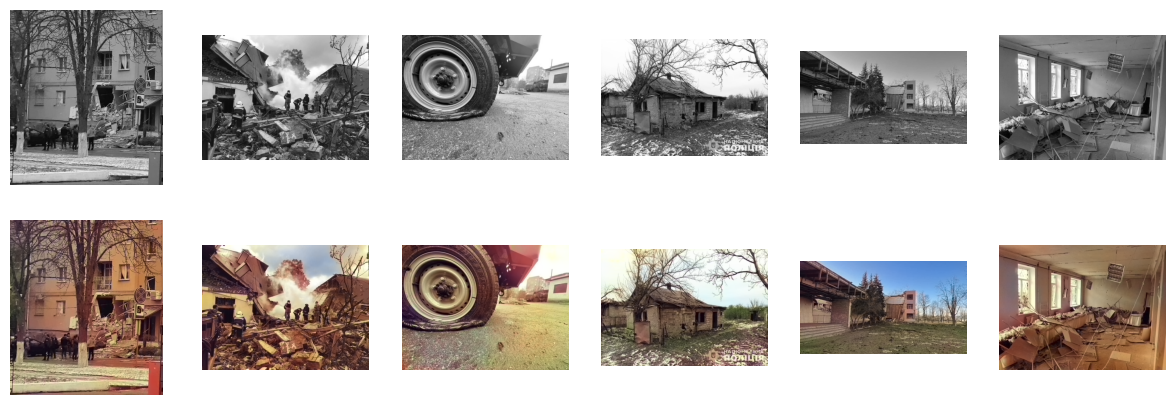

In [135]:
def train_eccv16(train_loader):
    for batch_idx, batch in enumerate(train_loader):
        save_grayscale_batch(batch)
        grayscale_batch = load_grayscale_batch(batch)
        
        grayscale_imgs = load_imgs(grayscale_batch)
        orig_l_list, rs_l_tensor = preprocess_imgs(grayscale_imgs)
        
        print(len(orig_l_list), orig_l_list[0].shape, rs_l_tensor.shape)
        
        output_tensor = model(rs_l_tensor)
        # print(output_tensor)
        print(output_tensor.shape)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            postprocessed_imgs = postprocess_imgs(orig_l_list, output_tensor)
        
        plt.figure()
        f, axarr = plt.subplots(2,6, figsize=(15, 5))
        for i in range(6):
            axarr[0,i].imshow(grayscale_imgs[i])
            axarr[0,i].axis('off')
            axarr[1,i].imshow(postprocessed_imgs[i])
            axarr[1,i].axis('off')
        
        del_grayscale_batch(batch)
        break
        
train_eccv16(train_loader)